In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [2]:
stack_fixed = 'MD589'
# stack_moving = 'atlas'
stack_moving = 'MD594'

In [3]:
detector_id = 1
warp_setting = 16

In [4]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True

upstream_warp_id                     None
transform_type                     affine
terminate_thresh                    1e-05
grad_computation_sample_number     100000
grid_search_sample_number            1000
std_tx_um                            2000
std_ty_um                            2000
std_tz_um                            2000
std_theta_xy_degree                    30
surround_weight                   inverse
regularization_weight                 NaN
comment                               NaN
Name: 16, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [5]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [6]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, detector_id=detector_id, prep_id=2,
                                                   sided=False, volume_type='score')

print volume_moving[1].shape

File does not exist: /shared/CSHL_volumes/MD594/MD594_down32_annotationVolume/MD594_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp"
(347, 538, 373)


File does not exist: /shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp'
Volume shape: (347, 538, 373)


In [7]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, detector_id=detector_id, prep_id=2,
                                                   sided=False, volume_type='score')

print volume_fixed[1].shape

File does not exist: /shared/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp"
(373, 485, 381)


File does not exist: /shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp'
Volume shape: (373, 485, 381)


In [8]:
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R']
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R', 
#                     'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
#                     'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R']
structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 
                    'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
                    'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R',
                   'Sp5C_L', 'Sp5C_R']

In [9]:
structure_subset = set([convert_to_original_name(name_s) for name_s in structure_subset])

In [10]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset}

# Computer registration

In [35]:
nzvoxels_m = {label: parallel_where_binary(vol > 0.8) for label, vol in volume_moving.iteritems()}

In [36]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f,
                  nzvoxels_m_=nzvoxels_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [37]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])

m: [ 269.   173.5  186.5] f: [ 242.5  186.5  190.5]


In [38]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                        grid_search_sample_number=5,
#                       std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                        grid_search_eta=3.)

In [39]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                          detector_id=detector_id, 
                                                         prep_id=2)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [40]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f)

set([2, 5, 7, 8, 16, 21, 22, 25, 26, 27, 28])


load gradient 2: 4.704736 seconds
load gradient 5: 4.339346 seconds
load gradient 7: 4.652784 seconds
load gradient 8: 6.195268 seconds
load gradient 16: 3.578496 seconds
load gradient 21: 3.827162 seconds
load gradient 22: 2.900202 seconds
load gradient 25: 5.195727 seconds
load gradient 26: 4.503525 seconds
load gradient 27: 3.399741 seconds
load gradient 28: 3.351811 seconds
overall: 46.650037 seconds


In [ ]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 5

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh=terminate_thresh,
                                     grad_computation_sample_number=10000,
                                     lr1=lr1, lr2=lr2)
#                                     init_T=grid_search_T)
        traj = aligner.Ts    
    
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(traj)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
2: 10000 samples out of 165076
5: 10000 samples out of 251620
7: 10000 samples out of 247410
8: 10000 samples out of 473293
16: 10000 samples out of 176105
21: 10000 samples out of 319712
22: 10000 samples out of 148922
25: 10000 samples out of 58269
26: 10000 samples out of 44132
27: 10000 samples out of 381864
28: 10000 samples out of 373950
in T: 0.00 0.00 0.00, out T: 9.85 9.91 9.88
step: 0.81 seconds
current score: 0.409270
new_T: [ 9.84835976  9.90697119  9.87859559]
det: 1.10

iteration 1
2: 10000 samples out of 164886
5: 10000 samples out of 246550
7: 10000 samples out of 246904
8: 10000 samples out of 472863
16: 10000 samples out of 156691
21: 10000 samples out of 323584
22: 10000 samples out of 153940
25: 10000 samples out of 55228
26: 10000 samples out of 34043
27: 10000 samples out of 392122
28: 10000 samples out of 359931
in T: 9.85 9.91 9.88, out T: 6.33 10.33 2.05
step: 0.84 seconds
current score: 0.357128
new_T: [  6.32673435  10.33285749   2.04627726]
det:

8: 10000 samples out of 501171
16: 10000 samples out of 177337
21: 10000 samples out of 331771
22: 10000 samples out of 160590
25: 10000 samples out of 58511
26: 10000 samples out of 44998
27: 10000 samples out of 388827
28: 10000 samples out of 390326
in T: 17.49 18.20 -5.32, out T: 18.80 16.86 -3.64
step: 0.85 seconds
current score: 0.752431
new_T: [ 18.80375402  16.86429774  -3.63626819]
det: 0.95

iteration 17
2: 10000 samples out of 164181
5: 10000 samples out of 248763
7: 10000 samples out of 245513
8: 10000 samples out of 499924
16: 10000 samples out of 176234
21: 10000 samples out of 333100
22: 10000 samples out of 161758
25: 10000 samples out of 58591
26: 10000 samples out of 45425
27: 10000 samples out of 391393
28: 10000 samples out of 394617
in T: 18.80 16.86 -3.64, out T: 17.42 19.39 -5.73
step: 0.86 seconds
current score: 0.769194
new_T: [ 17.41770594  19.3896928   -5.73326619]
det: 0.99

iteration 18
2: 10000 samples out of 164092
5: 10000 samples out of 248572
7: 10000 

22: 10000 samples out of 161714
25: 10000 samples out of 58472
26: 10000 samples out of 45190
27: 10000 samples out of 390606
28: 10000 samples out of 392586
in T: 19.22 18.89 -6.35, out T: 21.14 17.13 -4.64
step: 0.85 seconds
current score: 0.760287
new_T: [ 21.13706345  17.12593625  -4.63982585]
det: 0.96

iteration 33
2: 10000 samples out of 164262
5: 10000 samples out of 248894
7: 10000 samples out of 245671
8: 10000 samples out of 500617
16: 10000 samples out of 176340
21: 10000 samples out of 333449
22: 10000 samples out of 161536
25: 10000 samples out of 58563
26: 10000 samples out of 45250
27: 10000 samples out of 390991
28: 10000 samples out of 392727
in T: 21.14 17.13 -4.64, out T: 19.46 18.82 -5.90
step: 0.86 seconds
current score: 0.786712
new_T: [ 19.4591725   18.82047258  -5.89719   ]
det: 0.97

iteration 34
2: 10000 samples out of 164058
5: 10000 samples out of 248379
7: 10000 samples out of 245260
8: 10000 samples out of 501061
16: 10000 samples out of 177022
21: 10000 

[[  0.92761892  -0.26665      0.04667153  20.59176825]
 [  0.20935312   0.95594164  -0.06355155  17.7709757 ]
 [ -0.05525399   0.09464708   1.01646108  -5.20470477]]
0.794232236221 0.79143178463


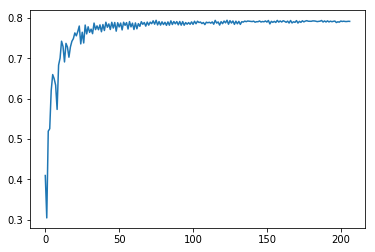

In [42]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

In [45]:
params_fp = \
DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              detector_id_f=detector_id,
                                              prep_id_f=2,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T, 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

##################################

history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              detector_id_f=detector_id,
                                              prep_id_f=2,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores), history_fp)
upload_to_s3(history_fp)

##################################

score_plot_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              detector_id_f=detector_id,
                                              prep_id_f=2,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)

upload_to_s3(score_plot_fp)

##################################

trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              detector_id_f=detector_id,
                                              prep_id_f=2,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_sco